In [66]:
import rasterio
import numpy as np
import skimage
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib
from matplotlib import pyplot
from skimage.segmentation import slic
from skimage.segmentation import watershed
from rasterio import features
from geopandas import GeoDataFrame
from collections import OrderedDict

In [4]:
%pwd

'/home/jovyan/learn_python'

In [33]:
src = rasterio.open("images/top_potsdam_6_11_RGBIR.tif")

In [34]:
src.count

4

In [10]:
src.width

6000

In [24]:
src.height

6000

In [35]:
image = src.read([1,2,3])

In [37]:
type(image)

numpy.ndarray

In [57]:
imagew = src.read([1,2,3], window=Window(2500,2500,512,512))

In [44]:
type(imagew)

numpy.ndarray

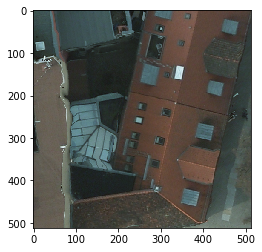

In [58]:
show(imagew)

In [65]:
#This is a SLIC algorithm
slic_params = {'compactness': 20,
              'n_segments': 50,
              'multichannel': True}
imaget = imagew.transpose(1, 2, 0)
rout = slic(imaget, **slic_params).astype('int32')

In [77]:
type(rout)

numpy.ndarray

In [72]:
#This is a quickshift algorithm
from skimage.segmentation import quickshift

quickshift_params = {'ratio': 0.3,
              'kernel_size': 10,
                    'max_dist': 100}
imaget = imagew.transpose(1, 2, 0)
rout = quickshift(imaget, **quickshift_params).astype('int32')

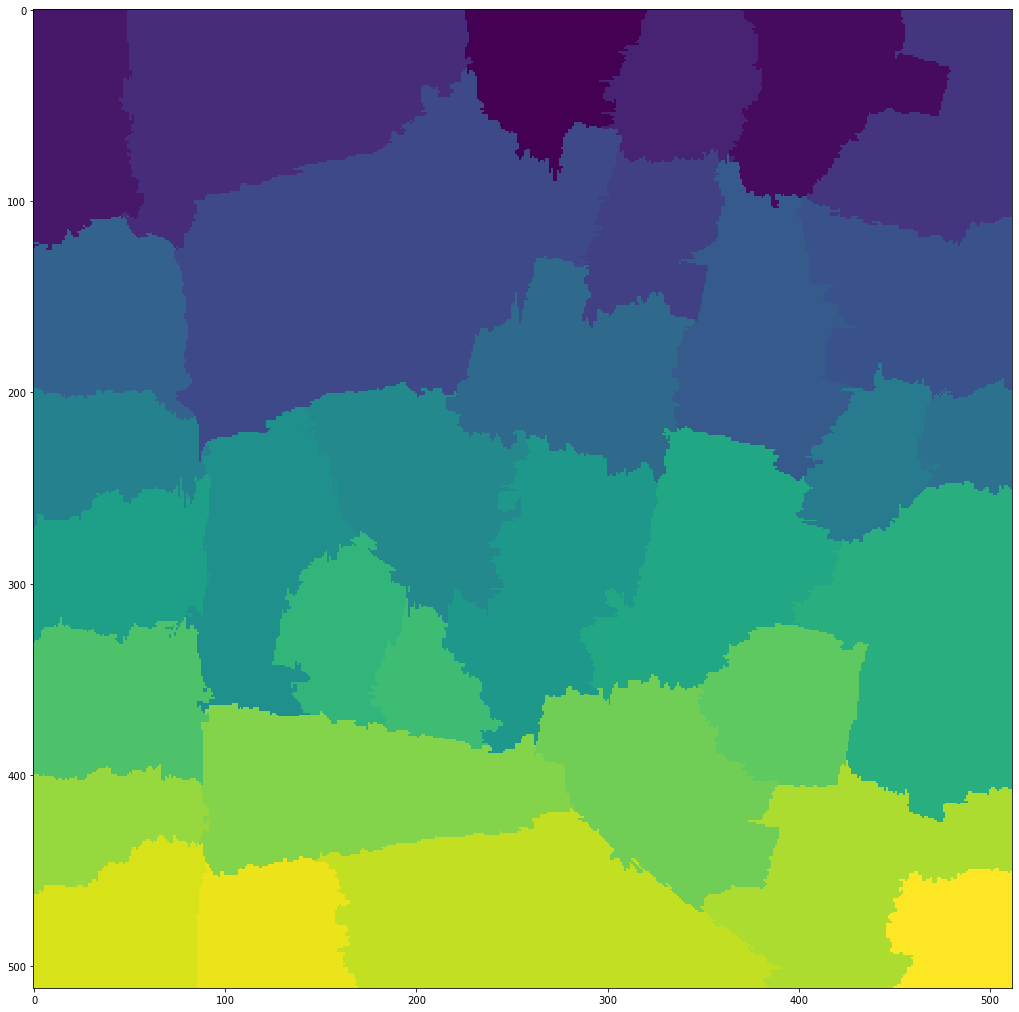

In [73]:
fig = pyplot.subplots(1, 1, figsize=(18,18))
show(rout)

In [78]:
type(rout)

numpy.ndarray

In [79]:
rout.shape

(512, 512)

In [83]:
temp= rout[:, :, np.newaxis]
temp.shape

(512, 512, 1)

In [84]:
output = rout[:, :, np.newaxis].transpose(2, 0, 1)
output.shape

(1, 512, 512)

In [102]:
ras = output[0]
ras.shape

(512, 512)

In [105]:
src

<open DatasetReader name='images/top_potsdam_6_11_RGBIR.tif' mode='r'>

In [86]:
src.transform

Affine(0.05, 0.0, 367276.5,
       0.0, -0.05, 5807362.6)

In [107]:
from rasterio import transform
transform.xy(src.transform, 2500, 2500)

(367401.525, 5807237.574999999)

In [93]:
from rasterio.transform import Affine
new_transform = Affine(0.05, 0.0, 367401.525, 0.0, -0.05, 5807237.574999999)


Affine(0.05, 0.0, 367401.525,
       0.0, -0.05, 5807237.574999999)

In [101]:
shps = features.shapes(ras, new_transform)
records = []

generator

In [113]:
ras = output[0]
        
shps = features.shapes(ras, transform=new_transform)
records = []

for id, shp in enumerate(shps):
    if shp[1] != 0:
        item = {'geometry': shp[0], 'id': id+1, 'properties': 
                OrderedDict([('dn', np.int(shp[1]))]),
                'type': 'Feature'}
        records.append(item)

vec = GeoDataFrame.from_features(records)
vec.crs = src.crs

In [114]:
vec = GeoDataFrame.from_features(records)
vec.crs = src.crs

In [115]:
vec.to_file("quichshift3.shp")